In this tutorial, we are going to build a forecasting model for a multivariate time series generated by a weather station. The time series data has already been preprocessed, and there are training and testing examples stored in separate files.

Let us read these files.

In [3]:
import pandas as pd

dfA652_train = pd.read_parquet('../data/atmoseer/A602_train.parquet.gzip')
dfA652_test = pd.read_parquet('../data/atmoseer/A602_test.parquet.gzip')

If we print the resulting shapes for dfA652_train and dfA652_train, we can see that they are indeed multivariate time series. 

Concretely, both are 8-dimensional time series.

For example, in dfA652_train, we have 10277 points (timestamps). In each timestamp, 8 variables are observed.

In [4]:
dfA652_train.shape, dfA652_test.shape

((10280, 8), (768, 8))

In [5]:
dfA652_train.head()

,temperature,barometric_pressure,relative_humidity,wind_direction_u,wind_direction_v,hour_sin,hour_cos,precipitation
2019-12-04 00:00:00,0.373832,0.480114,0.686869,0.403547,0.447290,0.500000,1.000000,0.0
2019-12-04 01:00:00,0.370717,0.485795,0.686869,0.383545,0.444438,0.629410,0.982963,0.0
2019-12-04 02:00:00,0.376947,0.494318,0.686869,0.382324,0.431581,0.750000,0.933013,0.0
2019-12-04 03:00:00,0.373832,0.491477,0.707071,0.431636,0.432161,0.853553,0.853553,0.0
2019-12-04 04:00:00,0.355140,0.477273,0.737374,0.468213,0.456114,0.933013,0.750000,0.0


<Axes: >

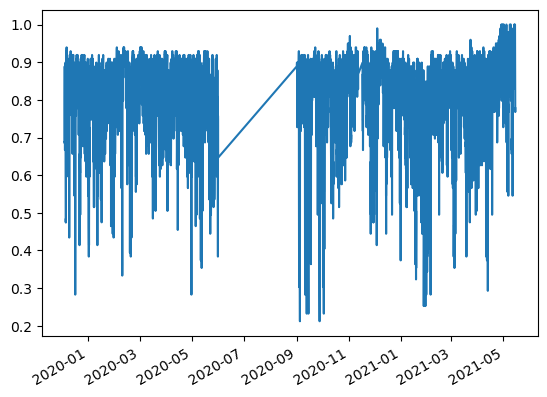

In [6]:
dfA652_train.relative_humidity.plot()

<Axes: >

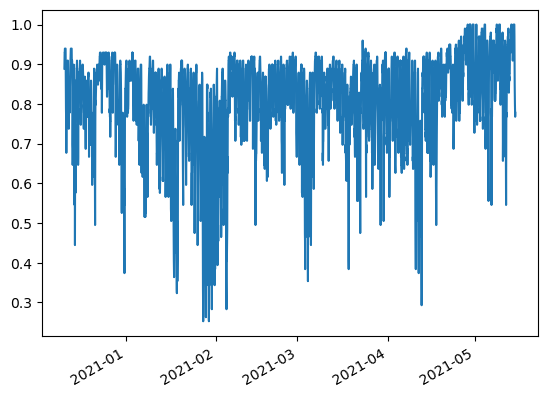

In [7]:
# Select rows occurring after December 11, 2020
df_selected = dfA652_train.loc['2020-12-11':]
df_selected.relative_humidity.plot()

## Rolling Window

The function provided below applies the rolling window techinique to put the time given series data into a tabular format.

In [8]:
import pandas as pd
import numpy as np

def apply_rolling_window(time_series_array,
                    initial_time_step,
                    max_time_step,
                    window_size,
                    target_idx):
    """
    Apply rolling window operation on a time series for sequence prediction tasks.

    Parameters:
    - time_series_array (numpy.ndarray): The input dataset, where rows are samples and columns are features.
    - initial_time_step (int): The starting time step for the windowing operation.
    - max_time_step (int): The maximum time step to consider in the windowing operation.
    - window_size (int): The size of the rolling window.
    - target_idx (int): The index of the target variable in the dataset.

    Returns:
    - X (numpy.ndarray): Resulting data matrix.
    - y (numpy.ndarray): Corresponding target values.

    The function applies a rolling window to the dataset, creating sub-windows of feature data and
    their corresponding target values. It handles missing values and ensures that the input data
    is valid for sequence prediction tasks.

    The rolling window is defined by 'initial_time_step', 'max_time_step', and 'window_size'.
    The 'target_idx' specifies the index of the target variable within the dataset.

    Note:
    - Ensure 'target_idx' is a valid column index within the dataset (0 <= target_idx < X.shape[1]).
    - The time steps should be non-negative (initial_time_step >= 0) and within a valid range
      (max_time_step >= initial_time_step).
    - The function handles missing (NaN) target values and identifies NaN values in feature windows.

    Example usage:
    >>> X, y = apply_windowing(time_series_array, initial_time_step=0, max_time_step=10, window_size=3, target_idx=0)
    """
    assert target_idx >= 0 and target_idx < time_series_array.shape[1]
    assert initial_time_step >= 0
    assert max_time_step >= initial_time_step

    start = initial_time_step

    sub_windows = (
        start +
        np.expand_dims(np.arange(window_size), 0) +
        np.expand_dims(np.arange(max_time_step + 1), 0).T
    )

    X, y = time_series_array[sub_windows], time_series_array[window_size:(
        max_time_step+window_size+1):1, target_idx]

    idx_y_train_not_nan = np.where(~np.isnan(y))[0]
    assert len(idx_y_train_not_nan) == len(y)

    x_train_is_nan_idx = np.unique(np.where(np.isnan(X)))

    return X, y

In [10]:
# Rolling window size. Should be define using, e.g., PACF.
window_size = 3

# Index of the column corresponding to the variable we want to define as the target.
# In this case, it is 'precipitation'.
target_idx = 7

# Apply rolling window to the training examples.
X_train, y_train = apply_rolling_window(
    time_series_array = dfA652_train.to_numpy(), 
    initial_time_step = 0, 
    max_time_step = len(dfA652_train) - window_size - 1, 
    window_size = window_size,
    target_idx = target_idx)

# Apply rolling window to the test examples.
X_test, y_test = apply_rolling_window(
    time_series_array = dfA652_test.to_numpy(), 
    initial_time_step = 0, 
    max_time_step = len(dfA652_test) - window_size - 1, 
    window_size = window_size,
    target_idx = target_idx)

We can now inspect the resulting shapes of the resulting numpy arrays, and compare with the shape of the input time series. 

In [11]:
dfA652_train.shape, X_train.shape, y_train.shape

((10280, 8), (10277, 3, 8), (10277,))

In [12]:
dfA652_test.shape, X_test.shape, y_test.shape

((768, 8), (765, 3, 8), (765,))

You should notice that both X_train and X_test are 3-dimensional arrays. To apply the learning algorithms provided by Scikit Learn, we should reshape these arrays. This is done in the following block of code.

## Reshaping the data

In [18]:
import numpy as np

print(f"Original shapes: {X_train.shape}/{X_test.shape}")
X_train = X_train.reshape(len(X_train), -1)
X_test = X_test.reshape(len(X_test), -1)
print(f"Resulting shapes: {X_train.shape}/{X_test.shape}")

Original shapes: (10277, 3, 8)/(765, 3, 8)
Resulting shapes: (10277, 24)/(765, 24)


Now are have our data in the shapes Scikit Learn expects them. We can go ahead and fit our forecasting model.

## Fitting a model

For simplicity's sake, let us define our forecasting task in the following way:
- we want to forecast precipitation values.
- prediction horizon: 1 step (i.e., we want to predict just one value of the target.)
- lead time: 1 step (i.e., we want to predict the target value 1 hour into the future.)
- windows size: 3 (i.e., we are going to use observations from the three past timesteps as features)

Also for simplicity's sake, let us frame the forecasting task as a binary classification problem. This means that we are going to binarize the (continuous) value of precipitation.

We are goingo to use `GradientBoostingClassifier` as our learning algorithm. You are encouraged to experiment with other learning algorithms. The code block below defines utilitary funcions to train and test our model.

In [13]:
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pickle
from sklearn.metrics import classification_report

def _train_and_test_classifier(X_train, y_train, X_test, y_test):

    # Frame the forecasting taks as a binary classification problem.
    y_train[y_train>0] = 1
    y_test[y_test>0] = 1

    assert len(np.unique(y_train)) == 2
    assert len(np.unique(y_test)) == 2
    
    # Create a GradientBoostingClassifier object with default hyperparameters
    clf = GradientBoostingClassifier()

    # Train the classifier
    clf.fit(X_train, y_train)
    
    # Make predictions on the testing data
    y_pred = clf.predict(X_test.reshape(len(X_test), -1))
    
    y_true = y_test
    y_true[y_true>0] = 1

    # Calculate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    return cm, y_true, y_pred

def report_results(cm, y_true, y_pred, title = None):
    # Define the class labels
    class_names = ['Negative', 'Positive']

    # Create a heatmap using Seaborn
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    # Add labels and title
    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    if title is not None:
        plt.title('Confusion Matrix - ' + title)
    else:
        plt.title('Confusion Matrix')

    # Show the plot
    plt.show()

    # Build the classification report
    target_names = ['Negative', 'Positive']
    report = classification_report(y_true, y_pred, target_names=target_names)

    # Print the classification report
    print(report)

Shapes of train/test data matrices: (10277, 24)/(765, 24)
[0. 1.]
[0. 1.]
2
2


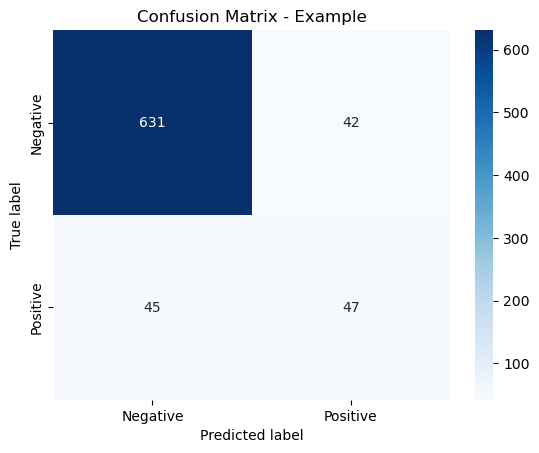

              precision    recall  f1-score   support

    Negative       0.93      0.94      0.94       673
    Positive       0.53      0.51      0.52        92

    accuracy                           0.89       765
   macro avg       0.73      0.72      0.73       765
weighted avg       0.88      0.89      0.89       765



In [20]:
print(f"Shapes of train/test data matrices: {X_train.shape}/{X_test.shape}")
cm, y_true, y_pred = _train_and_test_classifier(X_train, y_train, X_test, y_test)
report_results(cm, y_true, y_pred, "Example")

# PACF

Here is a simple example of using PACF to determine window size.

# pip install statsmodels

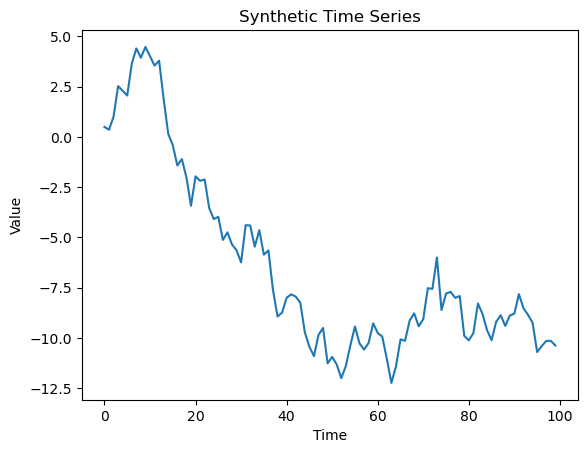

<Figure size 1000x400 with 0 Axes>

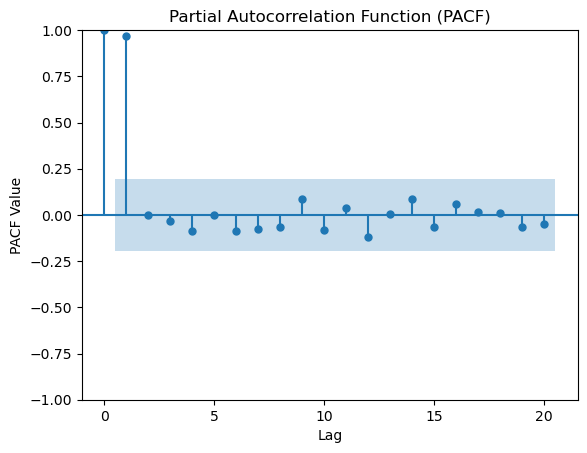

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf

# Generate a synthetic time series
np.random.seed(42)
n = 100
time_series = np.cumsum(np.random.normal(size=n))

# Plot the time series
plt.plot(time_series)
plt.title('Synthetic Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

# Calculate the PACF
lags = 20  # Number of lags to consider
pacf_values, confint = pacf(time_series, nlags=lags, alpha=0.05)

# Plot the PACF
plt.figure(figsize=(10, 4))
plot_pacf(time_series, lags=lags, alpha=0.05)
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lag')
plt.ylabel('PACF Value')
plt.show()


# Stationarity Check

Here is a simple example of performing statinarity check on a synthetic time series. This is done both visually and through the [Augmented_Dickey–Fuller hypothesis test](https://en.wikipedia.org/wiki/Augmented_Dickey–Fuller_test).

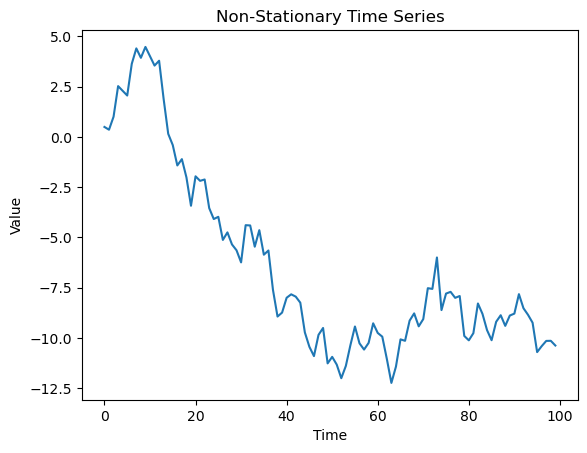

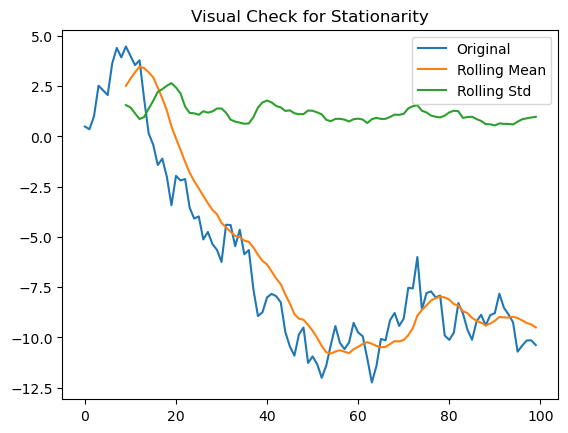

ADF Statistic: -1.3583317659818992
p-value: 0.6020814791099098
Critical Values: {'1%': -3.498198082189098, '5%': -2.891208211860468, '10%': -2.5825959973472097}
The time series is likely non-stationary.


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# Generate a synthetic time series (non-stationary)
np.random.seed(42)
n = 100
non_stationary_series = np.cumsum(np.random.normal(size=n))

# Plot the non-stationary time series
plt.plot(non_stationary_series)
plt.title('Non-Stationary Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

# Function to check stationarity visually
def check_stationarity_visual(time_series):
    rolling_mean = time_series.rolling(window=10).mean()
    rolling_std = time_series.rolling(window=10).std()

    plt.plot(time_series, label='Original')
    plt.plot(rolling_mean, label='Rolling Mean')
    plt.plot(rolling_std, label='Rolling Std')
    plt.legend()
    plt.title('Visual Check for Stationarity')
    plt.show()

# Function to check stationarity using ADF test
def check_stationarity_adf(time_series):
    result = adfuller(time_series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])
    
    if result[1] <= 0.05:
        print("The time series is likely stationary.")
    else:
        print("The time series is likely non-stationary.")

# Convert the synthetic time series to a pandas DataFrame with a timestamp index
df = pd.DataFrame({'value': non_stationary_series})

# Check stationarity visually
check_stationarity_visual(df['value'])

# Check stationarity using ADF test
check_stationarity_adf(df['value'])

# Removing Trend

A non stationary time series can be transformed into a stationary one, by removing its trend component. There are several alternative methods to do this. The code block below provides an example using a technique called [differencing](https://otexts.com/fpp2/stationarity.html). 

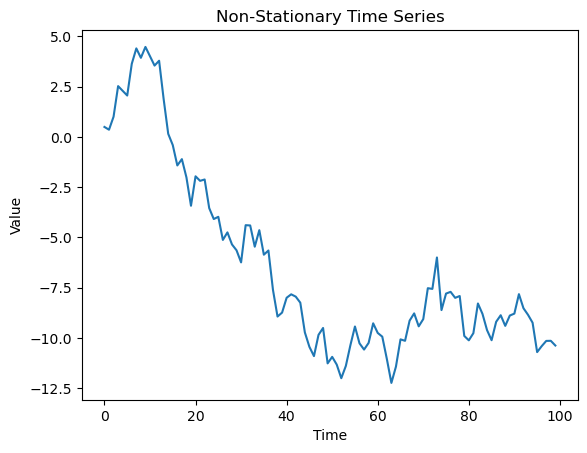

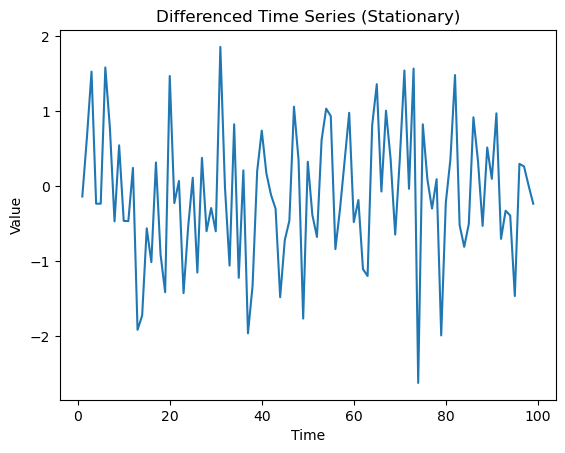

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# Generate a synthetic time series (non-stationary)
np.random.seed(42)
n = 100
non_stationary_series = np.cumsum(np.random.normal(size=n))

# Plot the non-stationary time series
plt.plot(non_stationary_series)
plt.title('Non-Stationary Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

# Function to check stationarity using ADF test
def check_stationarity_adf(time_series):
    result = adfuller(time_series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])
    
    if result[1] <= 0.05:
        print("The time series is likely stationary.")
    else:
        print("The time series is likely non-stationary.")

# Convert the synthetic time series to a pandas DataFrame with a timestamp index
df = pd.DataFrame({'value': non_stationary_series})

# Remove trend by differencing
df['stationary_series'] = df['value'].diff().dropna()

# Plot the differenced time series
plt.plot(df['stationary_series'])
plt.title('Differenced Time Series (Stationary)')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

## Decomposing a time series

To decompose a synthetic time series using the statsmodels library in Python, we can use the `seasonal_decompose` function. Below is an example code demonstrating how to do this.

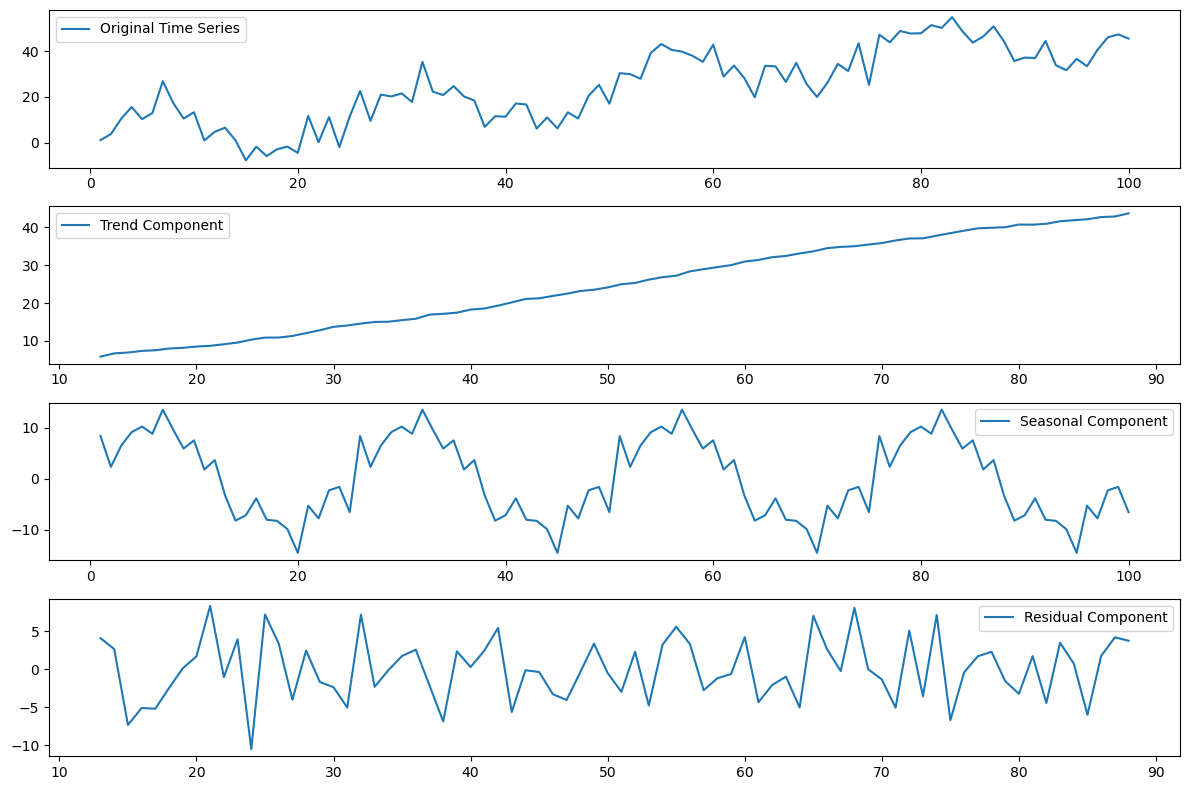

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Create a synthetic time series
np.random.seed(42)
time = np.arange(1, 101)
trend = 0.5 * time + np.random.normal(scale=5, size=100)
seasonal = 10 * np.sin(2 * np.pi * time / 25)
noise = np.random.normal(scale=3, size=100)
synthetic_series = trend + seasonal + noise

# Decompose the time series using statsmodels
result = sm.tsa.seasonal_decompose(synthetic_series, model='additive', period=25)  # Adjust the period based on your data

# Plot the original, trend, seasonal, and residual components
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(time, synthetic_series, label='Original Time Series')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(time, result.trend, label='Trend Component')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(time, result.seasonal, label='Seasonal Component')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(time, result.resid, label='Residual Component')
plt.legend()

plt.tight_layout()
plt.show()


# Extracting features related to datetime

The holidays library in Python is a useful tool for working with holidays and extracting features related to them. Here's an example of how you can use the holidays library and basice Python code to extract features from a fictitious dataset containing information about sales events.

In [3]:
pip install holidays

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 852.0/852.0 kB 17.7 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [16]:
import pandas as pd
import holidays

# Create a fictitious dataset
data = {
    'datetime': pd.date_range(start='2023-01-01', end='2023-02-18', freq='D'),
    'sales': [100, 150, 120, 130, 200, 180, 250, 300, 280, 150, 120, 130, 200, 180, 250, 300, 280, 150, 120, 130, 200, 180, 250, 300, 280, 150, 120, 130, 200, 180, 250, 300, 280, 150, 120, 130, 200, 180, 250, 300, 280, 150, 120, 130, 200, 180, 250, 300, 280],
}

df = pd.DataFrame(data)

# Create a column for holidays
us_holidays = holidays.UnitedStates()
df['is_holiday'] = df['datetime'].apply(lambda x: x in us_holidays)

# Extract features related to datetime
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day_of_week'] = df['datetime'].dt.day_of_week
df['day_of_month'] = df['datetime'].dt.day
df['is_weekend'] = df['datetime'].dt.day_of_week.isin([5, 6])


In [18]:
df.head()

,datetime,sales,is_holiday,year,month,day_of_week,day_of_month,is_weekend
0,2023-01-01,100,True,2023,1,6,1,True
1,2023-01-02,150,True,2023,1,0,2,False
2,2023-01-03,120,False,2023,1,1,3,False
3,2023-01-04,130,False,2023,1,2,4,False
4,2023-01-05,200,False,2023,1,3,5,False
